In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('..')

import dataset
import numbs
import tree_search
import backprop
import lpbackprop
import jump_backprop
import constraints
import utils

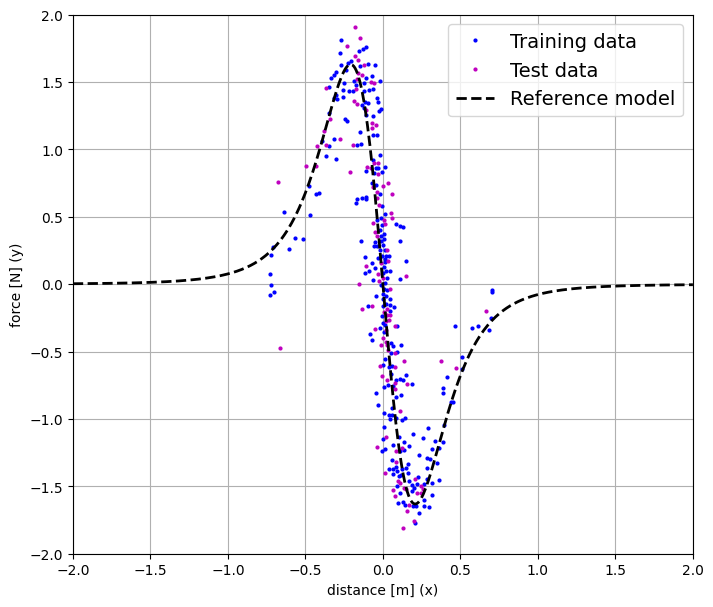

In [2]:
S = dataset.MagmanDatasetScaled()
#S.sample(size=250, noise=0.03, mesh=False)
S.load('../data/magman.csv')
S.split()
S.plot(width=8, height=7)

"""new_data = []
for dp in S.data:
    if dp.x < 0 and dp.y > 0 or \
       dp.x > 0 and dp.y < 0: new_data.append(dp)
S.data = new_data"""

S.index()
numbs.init(S)

S_train = dataset.NumpyDataset(S)
S_test  = dataset.NumpyDataset(S, test=True)

In [3]:
unknown_stree_a = backprop.UnknownSyntaxTree('A')
unknown_stree_b = backprop.UnknownSyntaxTree('B')
stree     = backprop.BinaryOperatorSyntaxTree('/', unknown_stree_a, unknown_stree_b)
#stree     = backprop.SyntaxTreeGenerator().create_random(5)[0]
stree_pr  = stree.diff().simplify()
stree_pr2 = stree_pr.diff().simplify()
print(str(stree))
print(str(stree_pr))
print(str(stree_pr2))

(A(x) / B(x))
(((A'(x) * B(x)) - (A(x) * B'(x))) / (B(x) ^ 2))
((((((A''(x) * B(x)) + (A'(x) * B'(x))) - ((A'(x) * B'(x)) + (A(x) * B''(x)))) * (B(x) ^ 2)) - (((A'(x) * B(x)) - (A(x) * B'(x))) * ((2 * B(x)) * B'(x)))) / (B(x) ^ 4))


In [4]:
hist_set = []
best_unkn_models = {}
best_eval = None

def onsynth_callback(synth_unkn_models:dict):
    global hist_set
    global best_unkn_models
    global best_eval
    
    print('--- On Synth ---')
    for unkn in synth_unkn_models.keys():
        unkn_model, unkn_model_d1, coeffs_mask, constrs = synth_unkn_models[unkn]
        print(f"{unkn}(x) =\n{unkn_model}")
    print()

    hist, __best_unkn_models, __best_eval = jump_backprop.jump_backprop(stree, stree_pr, synth_unkn_models, S_train, S_test, max_rounds=1)
    hist_set.append(hist)

    if best_eval is None or __best_eval.better_than(best_eval):
        best_unkn_models = __best_unkn_models
        best_eval = __best_eval

lpbackprop.lpbackprop(S.knowledge, stree, onsynth_callback)


--- ASP Model ---
sign_unkn("A","+",-4,-3) sign_unkn("A","+",-3,-2) sign_unkn("A","+",-2,-1) sign_unkn("A","+",-1,0) sign_unkn("A","-",0,1) sign_unkn("A","-",1,2) sign_unkn("A","-",2,3) sign_unkn("A","-",3,4) sign_unkn("B","+",-4,-3) sign_unkn("B","+",-3,-2) sign_unkn("B","+",-2,-1) sign_unkn("B","+",-1,0) sign_unkn("B","+",0,1) sign_unkn("B","+",1,2) sign_unkn("B","+",2,3) sign_unkn("B","+",3,4) sign_unkn("A'","-",1,2) sign_unkn("A'","-",2,3) sign_unkn("A'","-",3,4) sign_unkn("A'","-",-4,-3) sign_unkn("A'","-",-3,-2) sign_unkn("A'","-",-2,-1) sign_unkn("A'","-",0,1) sign_unkn("A'","-",-1,0) sign_unkn("B'","+",1,2) sign_unkn("B'","+",2,3) sign_unkn("B'","+",3,4) sign_unkn("B'","-",-4,-3) sign_unkn("B'","-",-3,-2) sign_unkn("B'","-",-2,-1) sign_unkn("B'","+",0,1) sign_unkn("B'","-",-1,0) sign_unkn("A''","+",0,1) sign_unkn("A''","+",1,2) sign_unkn("A''","-",-4,-3) sign_unkn("A''","-",-3,-2) sign_unkn("A''","+",2,3) sign_unkn("A''","+",3,4) sign_unkn("A''","-",-2,-1) sign_unkn("A''","-",

--- Best Syntax Tree ---
\frac{- 4.05908339706496 \cdot 10^{-5} x^{5} + 0.0135302791620144 x^{3} - 2.02954224439786 x}{120.801160646038 x^{6} - 20.5556947628223 x^{4} + 5.17180313241502 x^{2} + 0.0721031393164995}
None
Training
	mse: 0.4562490422062014
	rmse: 0.6754620953141645
	r2: 0.5643654003721387
Testing
	mse: 0.5656204682905461
	rmse: 0.7520774350361444
	r2: 0.4682629818110875
Knowledge
	mse: 0.29887832925981134
	rmse: 0.5466976579973718



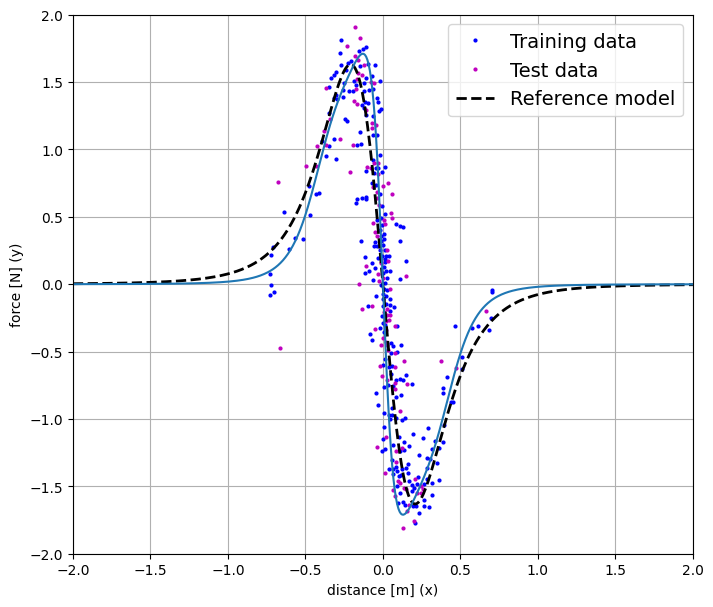

In [8]:
##
## set all synth_unkn_models.
##
#for model_name in synth_unkn_models_set[0].keys():
#    stree.set_unknown_model(model_name, *synth_unkn_models_set[0][model_name])

#
# show best stree.
#
if best_eval is None:
    #_, best_r2 = S.evaluate(stree.compute_output)
    raise RuntimeError('No model found.')
else:
    for unkn_label in best_unkn_models.keys():
        stree.set_unknown_model(unkn_label, best_unkn_models[unkn_label])

print("--- Best Syntax Tree ---")
import sympy
print(sympy.print_latex(stree.to_sympy()))
print(best_eval)
S.plot(width=8, height=7)
xp = np.linspace(S.xl, S.xu, 500)
plt.plot(xp, stree.compute_output(xp));
plt.show()


--- Pull from A(x) ---


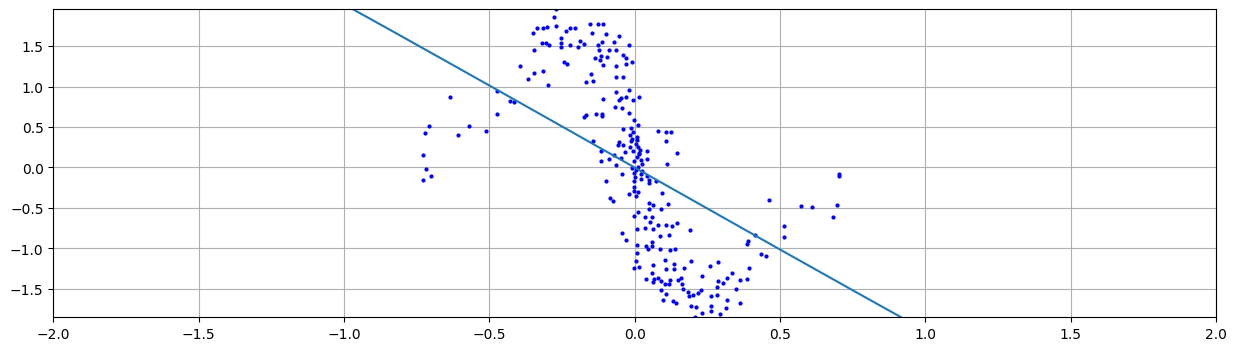

Model:
            5           3
-4.059e-05 x + 0.01353 x - 2.03 x
Coeffs Softmax:
[0.15681482 0.1568117  0.15681482 0.15785677 0.15681482 0.05807226
 0.15681482]
Coeffs:
[ 0.00000000e+00 -4.05908340e-05  0.00000000e+00  1.35302792e-02
  0.00000000e+00 -2.02954224e+00  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
Training
	mse: 0.4562490422062011
	rmse: 0.6754620953141642
	r2: 0.5643654003721392
Testing
	mse: 0.5656204682905458
	rmse: 0.7520774350361442
	r2: 0.46826298181108805
Knowledge
	mse: 0.29887832925981134
	rmse: 0.5466976579973718



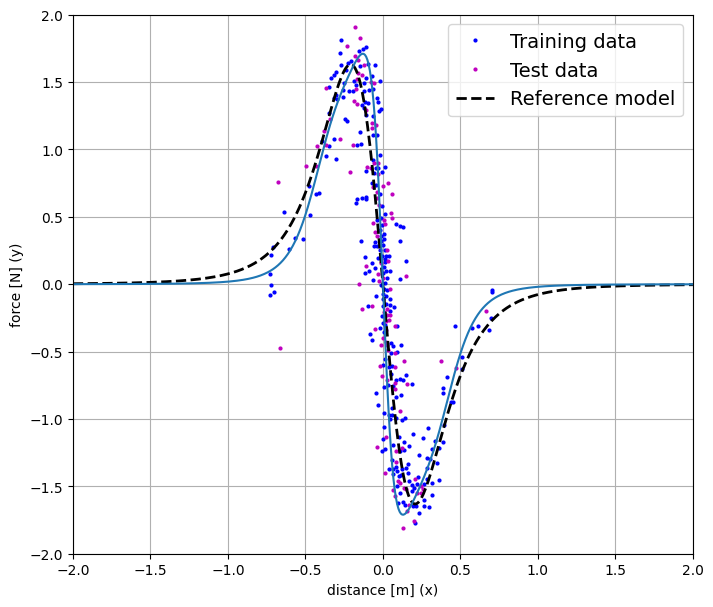



--- Pull from B(x) ---


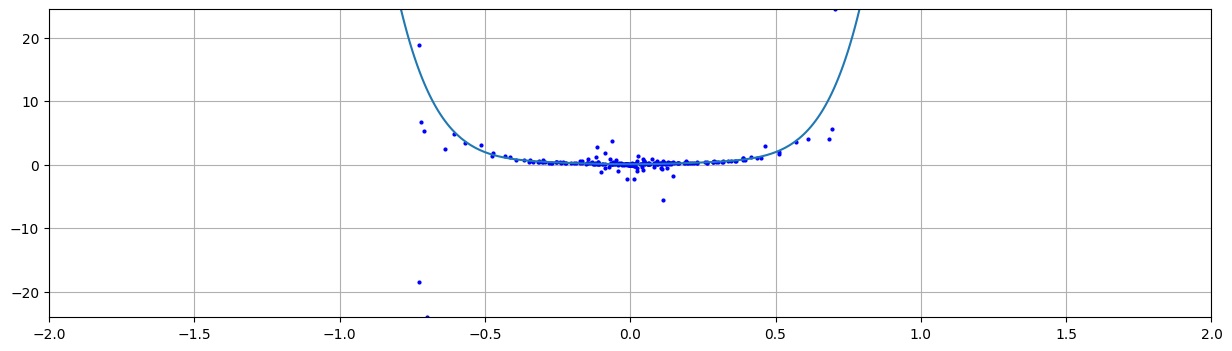

Model:
       6         4         2
120.8 x - 20.56 x + 5.172 x + 0.0721
Coeffs Softmax:
[0.28479854 0.12117055 0.10477153 0.12117055 0.1256859  0.12117055
 0.12123238]
Coeffs:
[ 1.20801161e+02  0.00000000e+00 -2.05556948e+01  0.00000000e+00
  5.17180313e+00  0.00000000e+00  7.21031393e-02]

--- Pulled Eq/Ineq Constraints ---

--- Final Model ---
Training
	mse: 0.4562490422062011
	rmse: 0.6754620953141642
	r2: 0.5643654003721392
Testing
	mse: 0.5656204682905458
	rmse: 0.7520774350361442
	r2: 0.46826298181108805
Knowledge
	mse: 0.29887832925981134
	rmse: 0.5466976579973718



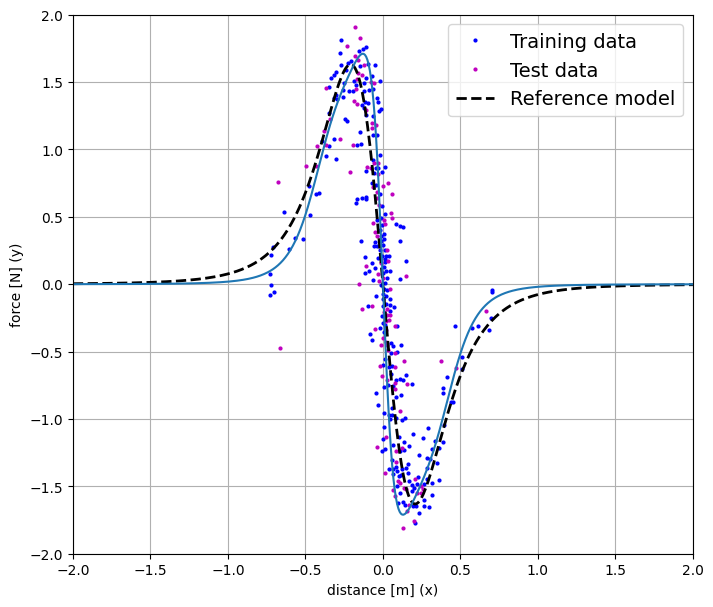



--- Pull from A(x) ---


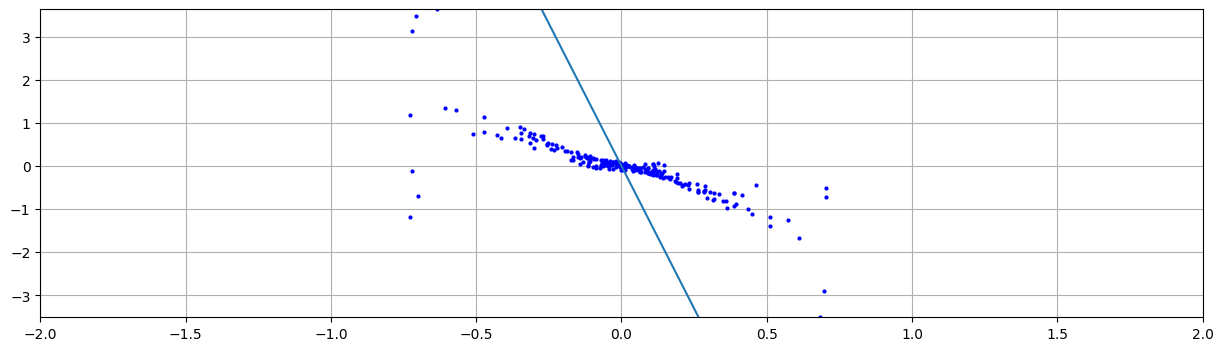

Model:
           3
3.095e-07 x - 13.22 x
Coeffs Softmax:
[0.15703815 0.15703815 0.15703815 0.15703815 0.15703815 0.05777111
 0.15703815]
Coeffs:
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  3.09505138e-07
  0.00000000e+00 -1.32225434e+01  0.00000000e+00]

--- Pulled Eq/Ineq Constraints ---
A(-0.20827333) = 0.43656625174182667
A(0.20827333) = -0.43656625174182667
A(-2.00000000) = 27.339145509285498
A(2.00000000) = -27.33914550928385

--- Final Model ---
Training
	mse: 52.56244810786767
	rmse: 7.249996421231369
	r2: -49.18754872603636
Testing
	mse: 55.85849619095499
	rmse: 7.473854172443759
	r2: -51.51229732697345
Knowledge
	mse: 13.37817362784238
	rmse: 3.6576185733127478



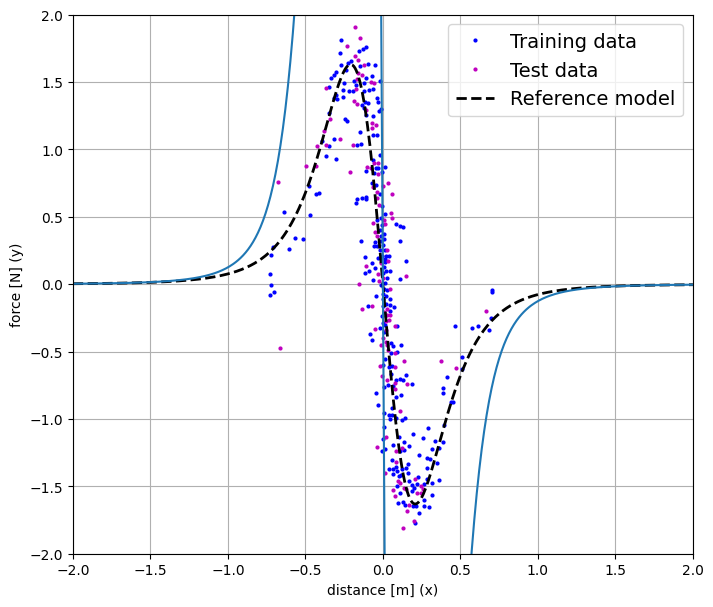



--- Pull from B(x) ---


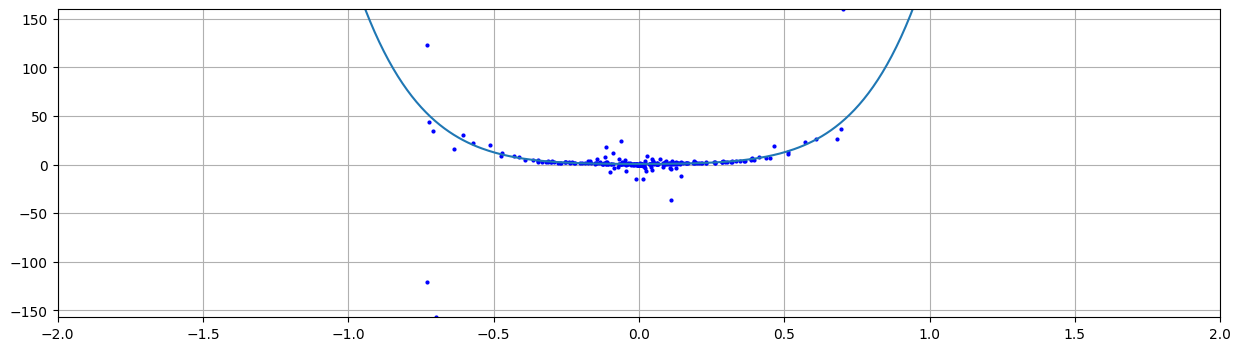

Model:
       6         4         2
83.41 x + 111.4 x + 14.87 x + 0.7311
Coeffs Softmax:
[0.21181886 0.1001797  0.27231665 0.1001797  0.11448604 0.1001797
 0.10083937]
Coeffs:
[ 83.40522684   0.         111.390255     0.          14.86918709
   0.           0.73109525]

--- Pulled Eq/Ineq Constraints ---
B(-0.20827333) = 1.6882122665591461
B(0.20827333) = 1.6882122665591461
B(-2.00000000) = 7180.386425203032
B(2.00000000) = 7180.386425203465

--- Final Model ---
Training
	mse: 0.37746734332810067
	rmse: 0.6143837101747577
	r2: 0.6395875502813397
Testing
	mse: 0.4352381437382216
	rmse: 0.6597258095134839
	r2: 0.5908347633654626
Knowledge
	mse: 7.738682570687623
	rmse: 2.781848768478909



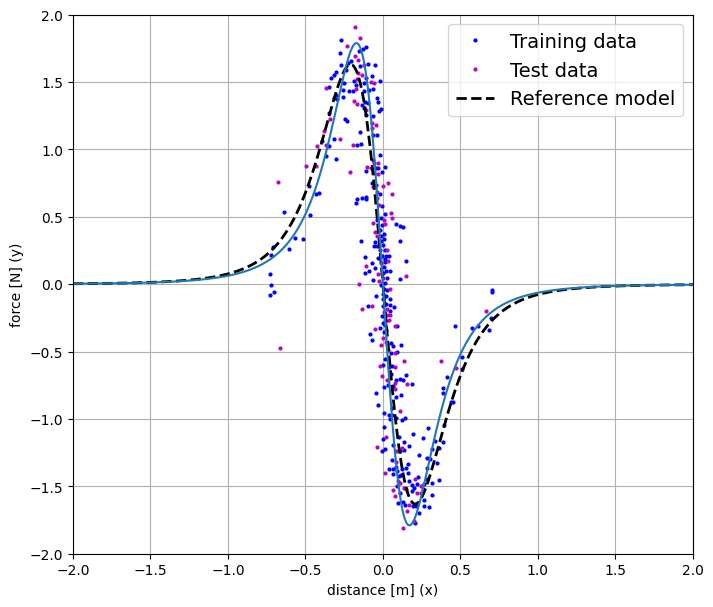

In [6]:
#
# show history (first Answer Set only).
#

constrmap = constraints.ConstraintMap()

for hist_entry in hist_set[0].entries:
    print(f"\n--- {hist_entry.msg} ---")
    
    if not hist_entry.pulled_S.is_empty():
        #y_scaled = utils.scale_y([dp.y for dp in hist_entry.pulled_S.data])
        #for i, dp in enumerate(hist_entry.pulled_S.data):
        #    dp.y = y_scaled[i]
        hist_entry.pulled_S.plot(width=15, height=4, plotref=False)
        xp = np.linspace(hist_entry.pulled_S.xl, hist_entry.pulled_S.xu, 500)
        plt.plot(xp, hist_entry.fit_model(xp));
        #plt.xlim(S.xl, S.xu)
        #plt.ylim(S.yl, S.yu)

        plt.show()
        #model, _ = utils.simplify_poly(hist_entry.fit_model, None)
        model = hist_entry.fit_model
        print(f"Model:\n{model}")
        print(f"Coeffs Softmax:\n{utils.coeffs_softmax(model.c)}")
        print(f"Coeffs:\n{model.c}")

    print("\n--- Pulled Eq/Ineq Constraints ---")
    for derivdeg in hist_entry.pulled_constrs.keys():
        for (dp, relopt) in hist_entry.pulled_constrs[derivdeg].eq_ineq:
            dp_x_str = "{:.8f}".format(dp.x)
            dp_y_str = str(dp.y) #"{:.8f}".format(dp.y)
            prime_sign = "'" * derivdeg
            constrmap.add(hist_entry.model_name + prime_sign, dp.x, dp.y, relopt)
            print(f"{hist_entry.model_name}{prime_sign}({dp_x_str}) {relopt.opt} {dp_y_str}")
    
    if len(hist_entry.violated_constrs) > 0:
        print("\n--- Violated Constraints ---")
        for (dp, relopt) in hist_entry.violated_constrs:
            dp_x_str = "{:.2f}".format(dp.x)
            dp_y_str = "{:.2f}".format(dp.y)
            print(f"m({dp_x_str}) {relopt.opt} {dp_y_str}")

    print("\n--- Final Model ---") 
    stree.set_unknown_model(hist_entry.model_name, hist_entry.fit_model)
    model_eval = S.evaluate(stree.compute_output)
    print(model_eval)
    
    S.plot(width=8, height=7)
    xp = np.linspace(S.xl, S.xu, 500)
    plt.plot(xp, stree.compute_output(xp));
    plt.show()

    print()